# Model Construction
### Choosing the package
This was the first project each of us have worked on that involved machine learning. Because of this we wanted to test a variety of different models to develop a breadth of knowledge. So we tried a few different models, starting with a simple linear regression and ending up utilizing a TensorFlow Sequential model. Along the way, we attempted to use a KNN model, a gradient boosted machine and a random forest. We ended up using a TensorFlow Sequential model because it produced the best mean absolute error. This was important because we want our model to predict the final score of NBA games with the least amount of error. 

### Models.py
To help in the training and hyperparameterization tuning in Tensorflow we created a small package to help. This includes funcitons to help compile, fit and test models. 

Now we will get into the actual construction of models. Remember from the EDA, we realized there were 2 classes of variables correlated to final score, derived statisitcs and base statistics. We will begin by testing which performs better. If they perform similarily, we will go with the base statistics to keep things simple and to make deployment easier.

### Overfitting
When initially training models, there overfitting was imedietely evident. To combat this, we implemented dropout layers between each dense layer. We also implemented an Earlystop callback to stop training the model once no progress was made. Combined, these drasticlaly reduced overfitting and made it a nonfactor.

In [56]:
# Importing necessary packages
from Models import *
import pandas as pd
import matplotlib.pyplot as plt


In [57]:
# Loading in the data
games = pd.read_csv("gamesDoubled.csv")
games = games.iloc[:, 1:]


In [58]:
# Defining a function to test different combinations of hyperparameters
def test_models(normalizer, X_train, X_test, y_train, y_test):
    nodes = [32, 64, 128]
    layers = [2, 4, 6]
    loss_func = ['mse', 'mae', 'huber']
    for node in nodes:
        for layer in layers:
            for func in loss_func:
                model = build_and_compile_model(normalizer, num_layers=layer, nodes=node,
                                                loss_func=func)
                fit_model(model, X_train, y_train)
                mae = find_mae(model, X_test, y_test)
                print(f"layers{layer}, nodes:{node}, loss_func:{func} \
                    results of an MAE of {mae}") 

In [59]:
# Building a model using derived statistics
# splitting test and train data for derived statisitcs
X_labels_derived = ['OFF_RATING', 'AST_RATIO', 'TS_PCT' ] 
y_label = 'final_PTS'
X_train_derived, X_test_derived, y_train_derived, y_test_derived = splitData(games, X_labels_derived, y_label)

In [60]:
# creating a normalizing layer to input data
normalizer_derived = createNormalizer(X_train_derived)

In [61]:
# splitting test and train data for base statisitcs
X_labels_base = ['FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'AST',
       'STL', 'BLK', 'TO', 'PF', 'half_PTS', 'Home']
y_label = 'final_PTS'
X_train_base, X_test_base, y_train_base, y_test_base = splitData(games, X_labels_base, y_label)

In [62]:
normalizer_base = createNormalizer(X_train_base)

In [8]:
# Testing the derived statistics
# Note this cell takes awhile to run
test_models(normalizer_derived, X_train_derived, X_test_derived, y_train_derived, y_test_derived)

layers2, nodes:32, loss_func:mse                     results of an MAE of 8.46093200896631
layers2, nodes:32, loss_func:mae                     results of an MAE of 8.393979891099647
layers2, nodes:32, loss_func:huber                     results of an MAE of 8.395528094972407
layers4, nodes:32, loss_func:mse                     results of an MAE of 9.073101640205318
layers4, nodes:32, loss_func:mae                     results of an MAE of 9.09207113109542
layers4, nodes:32, loss_func:huber                     results of an MAE of 9.814485787596379
layers6, nodes:32, loss_func:mse                     results of an MAE of 10.033336741928446
layers6, nodes:32, loss_func:mae                     results of an MAE of 10.364095415578047
layers6, nodes:32, loss_func:huber                     results of an MAE of 8.600970022258126
layers2, nodes:64, loss_func:mse                     results of an MAE of 8.395549388040006
layers2, nodes:64, loss_func:mae                     results of an MAE of 

In [9]:
# Testing the base statistics
# Note this cell takes awhile to run
test_models(normalizer_base, X_train_base, X_test_base, y_train_base, y_test_base)

layers2, nodes:32, loss_func:mse                     results of an MAE of 7.031172126916482
layers2, nodes:32, loss_func:mae                     results of an MAE of 6.959156586279212
layers2, nodes:32, loss_func:huber                     results of an MAE of 7.020774069048763
layers4, nodes:32, loss_func:mse                     results of an MAE of 8.852753029069351
layers4, nodes:32, loss_func:mae                     results of an MAE of 7.493286391120098
layers4, nodes:32, loss_func:huber                     results of an MAE of 10.279730976896968
layers6, nodes:32, loss_func:mse                     results of an MAE of 12.085956951627349
layers6, nodes:32, loss_func:mae                     results of an MAE of 7.696864432023665
layers6, nodes:32, loss_func:huber                     results of an MAE of 8.132665725361822
layers2, nodes:64, loss_func:mse                     results of an MAE of 6.984552067195766
layers2, nodes:64, loss_func:mae                     results of an MAE o

## The results
The results were quite similar between the 2 different classes of statistics. Note that the return MAE will vary each time the above codes are run. I selected the class of data and hyperparameters based on what consistently performed best. 

The hyperparameters that consistently performed the best was with 2 layers of 64 nodes using the mean squared erorr as the loss function. This will be the model we construct to make our predicions.

In [63]:
# Constructing final model
final_model = build_and_compile_model(normalizer_base, num_layers=2, nodes=64, loss_func='mse')
fit_model(final_model, X_train_base, y_train_base)

The MAE of our final model is: 7.078037761268815


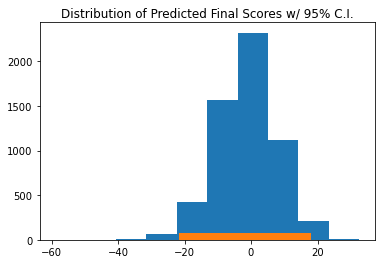

In [23]:
# Histogram of predictions
MAE = find_mae(final_model, X_test_base, y_test_base)
print("The MAE of our final model is: {}".format(MAE))
test_predictions = [item[0] for item in final_model.predict(X_test_base)]
differences = test_predictions - y_test_base
plt.hist(differences)
lower = np.percentile(differences, 2.5)
upper = np.percentile(differences, 97.5)
plt.plot((lower, upper), (0, 0), linewidth=15)
plt.title('Distribution of Predicted Final Scores w/ 95% C.I.')
plt.show()

In [15]:
# Saving the final model for NBA
final_model.save('finalModelNBA')

INFO:tensorflow:Assets written to: finalModel/assets


## WNBA Model
The results we got from our model trained to predict the final score of NBA predicted games wasn't performing quite to the accuracy we were hoping for. One way we tried to remedy this was to look for more data. During this process, we came across data from WNBA games. We had heard that WNBA are easier to predict so we went ahead and tried training a similar model on WNBA data and see if any improvements were made. 

To do this we will use the same technique used with NBA data and see if there are any noticeable differences. We will jump straight to training models with base statistics so we won't need the derived statistics in our doubled dataset.

In [6]:
womens_games = pd.read_csv("wnba_half_stats.csv")
womens_games = womens_games[womens_games['a_final_PTS'] >= 20]
womens_games = womens_games[womens_games['a_PLUS_MINUS'].notna()]
labels = ['FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'AST', 'STL', 'BLK', 'TO',
          'PF', 'half_PTS', 'final_PTS']
a_labels = ['a_'+label for label in labels]
h_labels = ['h_'+label for label in labels]
new_columns = h_labels + a_labels
womens_games = womens_games[new_columns]
womens_games = womens_games.drop_duplicates()
new_labels = ['FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'AST', 'STL', 'BLK', 'TO',
          'PF', 'half_PTS', 'final_PTS', 'Home']
a_games = womens_games[a_labels]
a_games['Home_team'] = 0
a_games.columns = new_labels
h_games = womens_games[h_labels]
h_games['Home_team'] = 1
h_games.columns = new_labels
womens_games = h_games.append(a_games)
womens_games.to_csv("womensGamesDoubled.csv")
womens_games.head()


<ipython-input-6-1dd21ee33bb2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a_games['Home_team'] = 0
<ipython-input-6-1dd21ee33bb2>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_games['Home_team'] = 1


,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,AST,STL,BLK,TO,PF,half_PTS,final_PTS,Home
0,13.0,32.0,2.0,3.0,6.0,8.0,5.0,10.0,8.0,4.0,1.0,11.0,10.0,34.0,59.0,1
1,18.0,36.0,3.0,7.0,3.0,3.0,7.0,14.0,13.0,3.0,1.0,10.0,12.0,42.0,91.0,1
2,13.0,44.0,7.0,12.0,7.0,8.0,9.0,11.0,9.0,2.0,2.0,4.0,6.0,40.0,80.0,1
3,18.0,38.0,3.0,10.0,6.0,6.0,4.0,13.0,14.0,7.0,3.0,5.0,8.0,45.0,63.0,1
4,11.0,34.0,3.0,12.0,6.0,6.0,5.0,13.0,6.0,2.0,3.0,11.0,7.0,31.0,71.0,1


In [7]:
X_womens = womens_games.columns.drop('final_PTS')
y_womens = 'final_PTS'
X_train_womens, X_test_womens, y_train_womens, y_test_womens = splitData(womens_games, X_womens, y_womens)
normalizer_womens = createNormalizer(X_train_womens)

In [19]:
test_models(normalizer_womens, X_train_womens, X_test_womens, y_train_womens, y_test_womens)

layers2, nodes:32, loss_func:mse                     results of an MAE of 7.2965599738227
layers2, nodes:32, loss_func:mae                     results of an MAE of 9.915652330186632
layers2, nodes:32, loss_func:huber                     results of an MAE of 9.6822886912028
layers4, nodes:32, loss_func:mse                     results of an MAE of 8.41173334757487
layers4, nodes:32, loss_func:mae                     results of an MAE of 9.989475267198351
layers4, nodes:32, loss_func:huber                     results of an MAE of 12.299133292304145
layers6, nodes:32, loss_func:mse                     results of an MAE of 11.404505174424914
layers6, nodes:32, loss_func:mae                     results of an MAE of 9.746273820665147
layers6, nodes:32, loss_func:huber                     results of an MAE of 9.888686684502495
layers2, nodes:64, loss_func:mse                     results of an MAE of 9.25046979268392
layers2, nodes:64, loss_func:mae                     results of an MAE of 9.95

## WNBA Results
The best performing model for predicting WNBA games had 4 layers, 128 nodes and used the mean squared error loss function. We will train a model with the selected hyperparameters and save it so that we can deploy it. 

In [8]:
final_WNBAModel = build_and_compile_model(normalizer_womens, num_layers=4, nodes=128, loss_func='mse')
fit_model(final_WNBAModel, X_train_womens, y_train_womens)
final_WNBAModel.save("final_WNBAModel")

INFO:tensorflow:Assets written to: final_WNBAModel/assets


In [25]:
womens_mae = find_mae(final_WNBAModel, X_test_womens, y_test_womens)
womens_mae

5.285559675428602

In [15]:
womens_mae / np.mean(y_train_womens)

0.07113609098896567

In [24]:
MAE / np.mean(y_train_base)

0.06836121960191514



## Conclusion 
Now we have our final model that we can use to predict final score. We can now go forward with implementing the models we created. 